## Engagement Prediction

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. The main objective of this project is to predict how engaging a video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

## About the dataset

Datasets were extracted from the VLE Dataset put together by researcher Sahan Bulathwela at University College London. 

Each row in these files corresponds to a single video, and includes information about diverse properties of the video content as described further below. The target variable is `engagement` which was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise.

**Data fields**

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
    engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.
    

In [1]:
import os
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#Data exploration
data = pd.read_csv('assets/train.csv')
data

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,1,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.000000,True
1,2,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.000000,False
2,3,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.000000,False
3,4,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.000000,False
4,5,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...
9234,9235,7,7.820262,14170,82.302473,0.587838,0.027449,2.120000,0.250322,False
9235,9236,6,8.781639,14410,83.361440,0.588235,0.012465,2.251447,0.000000,False
9236,9237,5,7.643789,16240,82.425897,0.611600,0.034213,2.728182,0.000000,False
9237,9238,6,7.985593,14500,87.565381,0.630815,0.020167,2.529861,0.300094,False


In [4]:
data.describe()

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
count,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000
mean,4620.000000,7.701050,7.792685,14808.587509,84.756029,0.612214,0.021354,2.413320,0.146606
std,2667.213902,3.785066,0.697710,1208.953646,8.303489,0.051872,0.009545,1.588296,0.172030
min,1.000000,1.000000,0.000000,10830.000000,28.210966,0.000000,0.000000,0.000302,0.000000
25%,2310.500000,5.000000,7.594235,14070.000000,80.415060,0.589632,0.014974,1.976727,0.000000
50%,4620.000000,7.000000,7.875103,14750.000000,84.482122,0.613127,0.019843,2.267133,0.104915
75%,6929.500000,10.000000,8.164166,15600.000000,88.388711,0.634585,0.026288,2.539207,0.250927
max,9239.000000,33.000000,9.278573,17430.000000,122.032000,1.000000,0.101990,50.850000,1.168239


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9239 entries, 0 to 9238
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9239 non-null   int64  
 1   title_word_count            9239 non-null   int64  
 2   document_entropy            9239 non-null   float64
 3   freshness                   9239 non-null   int64  
 4   easiness                    9239 non-null   float64
 5   fraction_stopword_presence  9239 non-null   float64
 6   normalization_rate          9239 non-null   float64
 7   speaker_speed               9239 non-null   float64
 8   silent_period_rate          9239 non-null   float64
 9   engagement                  9239 non-null   bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 658.8 KB


In [3]:
data.drop('id', axis=1, inplace = True)

In [7]:
data.head()

,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.0,True
1,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.0,False
2,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.0,False
3,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.0,False
4,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.0,False


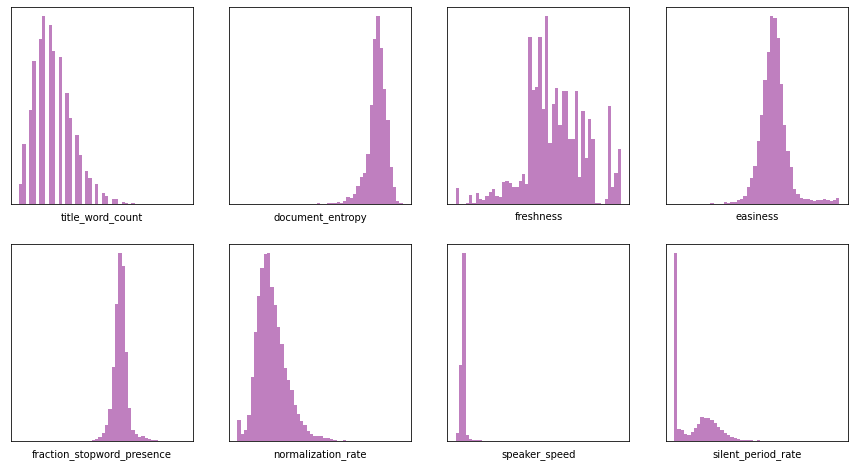

In [32]:
#Data Visualizations

ncols = 4
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))

counter = 0
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        if counter < len(data.columns):
            ax.hist(data[data.columns[counter]], bins=50, color='purple', alpha=0.5, density = True)
            ax.set_xlabel(data.columns[counter])
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.set_axis_off()
        counter += 1

plt.show()

In [35]:
data['engagement'].value_counts()

False    8342
True      897
Name: engagement, dtype: int64

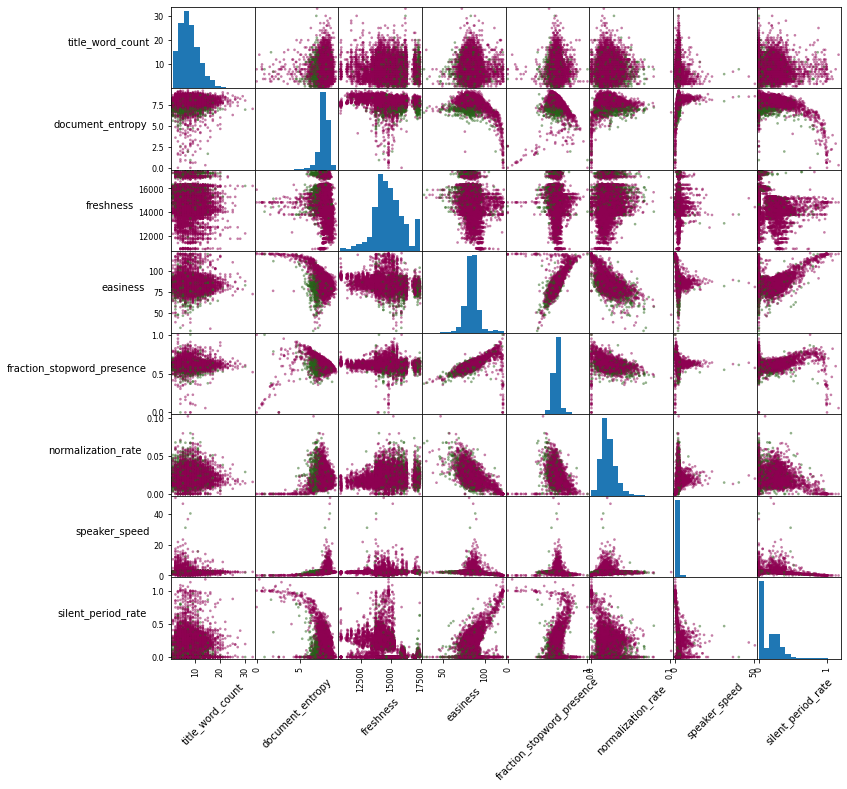

In [7]:
#Visualization of the relation between the label and the features

from matplotlib import cm

X = data[['title_word_count', 'document_entropy', 'freshness', 'easiness', 'fraction_stopword_presence',
          'normalization_rate', 'speaker_speed', 'silent_period_rate']]
y = data['engagement']

cmap = cm.get_cmap('PiYG')
scatter = pd.plotting.scatter_matrix(X, c= y, marker = 'o', s=7, hist_kwds={'bins':15}, figsize=(12,12), cmap=cmap)
for ax in scatter.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

Now that the data was explored, we proceed to analyze different classifiers so we achieve the goal proposed. First we divide the data set into training and test sets so we can test our model. Then we try to look for the best possible parameters for the models. The model will be evaluated using the Area Under the ROC Curve (AUC) as a metric.

In [4]:
y = data['engagement']
X = data.drop('engagement', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [5]:
#Random Forest Classifier Model

model1 = RandomForestClassifier()

param1 = {'n_estimators': [10,50,100,300,500], 'max_depth': [1,5,10,15],
          'criterion' : ['gini', 'entropy', 'log_loss']}

grid_model1 = GridSearchCV(model1, param_grid = param1, scoring = 'roc_auc', cv=5)
grid_model1.fit(X_train, y_train)
y_decision_g1 = grid_model1.predict_proba(X_test)

print('Test set AUC: ', roc_auc_score(y_test, y_decision_g1[:,1]))
print('Grid best parameter (max. AUC): ', grid_model1.best_params_)
print('Grid best score (AUC): ', grid_model1.best_score_)

Test set AUC:  0.8817706998205588
Grid best parameter (max. AUC):  {'criterion': 'log_loss', 'max_depth': 10, 'n_estimators': 300}
Grid best score (AUC):  0.8958509079923583


The computational time to fit this model is almost 10 minutes

In [31]:
#Gradient Boosting Classifier

model2 = GradientBoostingClassifier()

param2 = {'n_estimators': [10,50,100,300,500], 'max_depth': [1,5,10,15],
          'learning_rate' : [0.01,0.1,0.5,1]}

grid_model2 = GridSearchCV(model2, param_grid = param2, scoring = 'roc_auc', cv=5)
grid_model2.fit(X_train, y_train)
y_decision_g2 = grid_model2.predict_proba(X_test)

print('Test set AUC: ', roc_auc_score(y_test, y_decision_g2[:,1]))
print('Grid best parameter (max. AUC): ', grid_model2.best_params_)
print('Grid best score (AUC): ', grid_model2.best_score_)

Test set AUC:  0.8785519738528583
Grid best parameter (max. AUC):  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
Grid best score (AUC):  0.8913001235128221


The computational time to fit this model is around 26 minutes

Having those two models we can see that there's no big difference on the AUC score, but there's a major difference in the computational time they use. For this reason we select the Random Forest Classifier as the model for this task

Let's review some other scores for that model

In [6]:
from sklearn.metrics import classification_report

y_predicted = grid_model1.predict(X_test)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

       False       0.94      0.99      0.96      1660
        True       0.81      0.39      0.53       188

    accuracy                           0.93      1848
   macro avg       0.87      0.69      0.75      1848
weighted avg       0.92      0.93      0.92      1848



In [ ]:
The scores let 